In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.model_selection import *

from sklearn.cluster import KMeans
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelBinarizer
import multiprocessing as mp
import time
import csv
from tqdm.notebook import tqdm

# метрика задачи
def score(y_true, y_val):
    return f1_score(y_true, y_val, average='macro')

In [3]:
train =  pd.read_csv('alfabattle2_abattle_train_target.csv', parse_dates=['timestamp'])
train = train.sort_values('timestamp')
test = pd.read_csv('alfabattle2_prediction_session_timestamp.csv', parse_dates=['timestamp'])
test = test.set_index('client_pin')['timestamp']

### Extraction training features

In [ ]:
ALFA_COEF = 0.07 # гиперпараметр, требующий тюнинга

def EMA(alfa, array: np.ndarray):
    res = np.zeros(array.shape, dtype='float16')
    res[1] = array[0]
    for nrow in range(2, array.shape[0]):
        res[nrow] = alfa * array[nrow-1] + (1-alfa) * res[nrow-1]
    return res



CLASSES = ['card2card_transfer',
          'card_recharge',
          'chat',
          'credit_info',
          'invest',
          'main_screen',
          'mobile_recharge',
          'own_transfer',
          'phone_money_transfer',
          'statement']
          

lb = LabelBinarizer().fit(CLASSES)


CLASSES_DQ = [i+'_day_quarter' for i in CLASSES]
CLASSES_DW = [i+'_dw' for i in CLASSES]
CLASSES_NW = [i+'num_week' for i in CLASSES]
time_features = ['secs_since_12AM', 'day', 'day_week', 'num_week', 'day_quarter'] 
client_features = ['prev_session_cnt', 'time_since_last', 'usage_time', 'breaks']
client_features += CLASSES + CLASSES_DQ + CLASSES_DW + CLASSES_NW



def set_class_probs(data: pd.DataFrame, by, names):
    for _, spam in data.groupby(by):
        if len(spam) > 1:
            data.loc[spam.index, names] = EMA(ALFA_COEF, lb.transform(spam.multi_class_target))




def extract_time_features(train: pd.DataFrame):
    timestamp = train.timestamp.dt
    train['secs_since_12AM'] = 3600 * timestamp.hour + 60 * timestamp.minute + timestamp.second
    train['day'] = timestamp.day
    train['day_week'] = timestamp.dayofweek
    train['num_week'] = pd.cut(train['day'], [1, 7, 15, 23, 31], include_lowest=True).cat.codes
    train['day_quarter']= pd.cut(timestamp.hour, [0, 5, 11, 17, 23], include_lowest=True).cat.codes
    # train.drop('timestamp', 1, inplace=True)

extract_time_features(train)
train.head()

In [77]:
def extract_client_features(data: pd.DataFrame) -> pd.DataFrame:
    data[client_features] = np.nan

    # количество предыдущих сессий
    data['prev_session_cnt'] = range(len(data))

    if len(data) > 1:
        # timestamp первой сессии
        first_session_ts = data.timestamp.iloc[0]
        # время с последней сессии
        data['time_since_last'] = data.timestamp.diff().dt.total_seconds()
        # сколько всего пользуется приложением
        data['usage_time'] = (data.timestamp - first_session_ts).dt.total_seconds()
        # в среднем перерывы между сессиями
        data['breaks'] = data['usage_time'] / data['prev_session_cnt'] # в oo не уходит

        # вероятность действия X
        data[CLASSES] = EMA(ALFA_COEF, lb.transform(data.multi_class_target))

        # вероятность действия по интервалам суток
        set_class_probs(data, 'day_quarter', CLASSES_DQ)

        # вероятность действия X по дню недели
        set_class_probs(data, 'day_week', CLASSES_DW)

        # вероятность по текущей четверти месяца
        set_class_probs(data, 'num_week', CLASSES_NW)
    return data

spam = train[train.client_pin == 'bdfb2a491cb1a146358319b6955d7308'].copy()
feature_names = extract_client_features(spam).columns

In [ ]:
import multiprocessing as mp
from tqdm import tqdm, trange
import time

def worker(data):
    result = extract_client_features(data).values
    return result

def main():  
    pool = mp.Pool(6)

    with open('features.csv', mode='w') as csv_file:
        writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(feature_names)

        jobs = []

        for client, data in train.groupby('client_pin'):
            job = pool.apply_async(worker, (data,))
            jobs.append(job)

        for i in trange(len(jobs)): 
            writer.writerows(jobs[i].get())
            # avoid memory leak
            jobs[i] = None
            

    pool.close()
    pool.join()

if __name__ == '__main__':
    main()

### Reading data with extracted features

In [2]:
df = pd.read_csv('features.csv')

In [5]:
df.multi_class_target.value_counts()

main_screen             2280763
statement                922569
credit_info              498698
own_transfer             290077
mobile_recharge          266485
phone_money_transfer     232911
card2card_transfer       193378
chat                     184775
card_recharge            138616
invest                    57078
Name: multi_class_target, dtype: int64

Среднее количество сессий

In [57]:
df.groupby('client_pin').apply(len).mean()

63.90157440581319

Максимальное количество сессий

In [59]:
df.groupby('client_pin').apply(len).max()

1646

Диаграммы рассеяния для признаков, относящихися к инвестициям

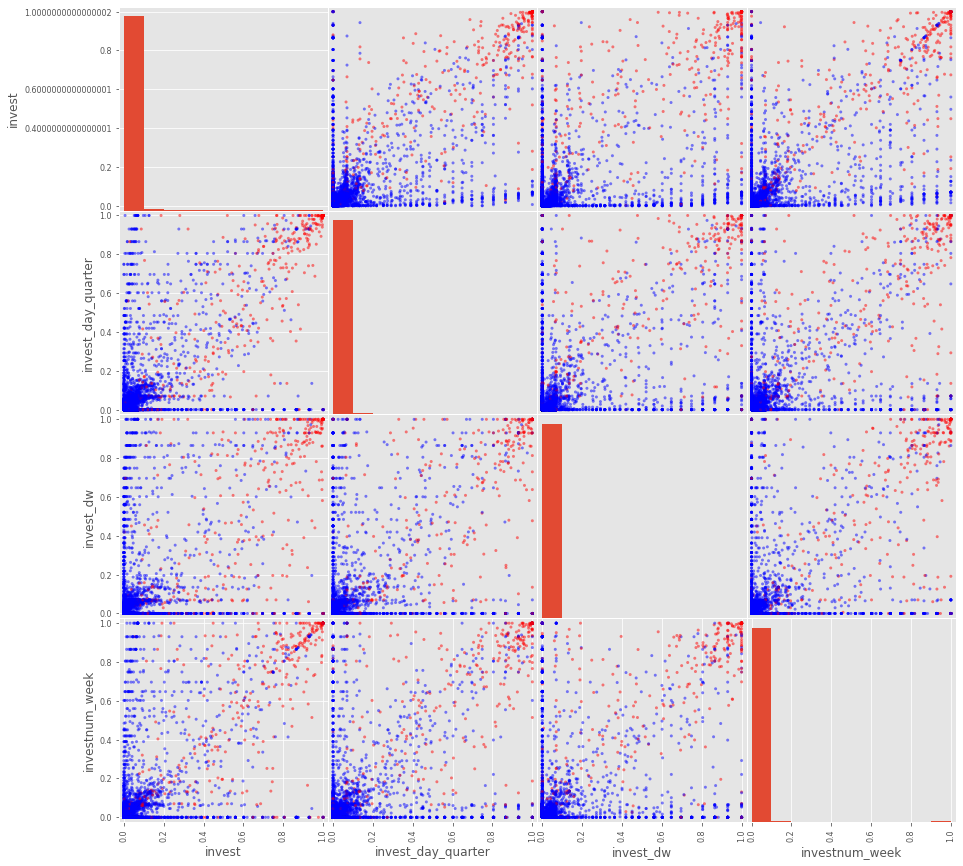

In [132]:
col = 'invest'
data = df.loc[:, df.columns.str.startswith(col) | (df.columns == 'multi_class_target')].sample(50000)
pd.plotting.scatter_matrix(data, figsize=(15,15), c=(data.multi_class_target == col).astype(int).map({0: 'b', 1: 'r'}));

In [20]:
# def group_val_score(X: pd.DataFrame, groups: pd.Series):
#     group_kfold = GroupKFold(n_splits=5)
#     train_idx, test_idx = next(group_kfold.split(X, groups=groups))
#     return X.iloc[train_idx], X.iloc[test_idx]

In [3]:
to_scale = [
    'secs_since_12AM',
    'time_since_last',
    'usage_time',
    'breaks',
]
scaler = StandardScaler()
models = {}
classes = df.multi_class_target.unique().tolist()

In [13]:
# df = df.sample(500_000)
df[to_scale] = scaler.fit_transform(df[to_scale])
df.fillna(0, inplace=True)

# time series split
df.sort_values('timestamp', inplace=True)
train_size = int(0.8 * len(df))
train_df, test_df = df[:train_size], df[train_size:] 
assert train_df.timestamp.max() <= test_df.timestamp.min()

# group split
# train_df, test_df = group_val_score(df, df['client_pin'])

### Modeling

ОБучение моделей по каждому классу с группой фичей

In [16]:
def preprocess(train_df, test_df, cls):
    y_train, y_test = ((df.multi_class_target == cls).astype(int) for df in (train_df, test_df))
    cls_cols = df.columns[df.columns.str.startswith(cls)].tolist() + to_scale +['day', 'day_week', 'day_quarter']
    train_df, test_df = (df[cls_cols].copy() for df in (train_df, test_df))
    return train_df, test_df, y_train, y_test

  0%|          | 0/10 [00:00<?, ?it/s]

In [17]:
def make_predictions(models, test_df):
    predicts = pd.DataFrame(np.zeros((len(test_df), len(classes))), columns=classes)
    for cls in tqdm(classes):
        cls_cols = df.columns[df.columns.str.startswith(cls)].tolist() + to_scale + ['day', 'day_week', 'day_quarter']
        predicts[cls] = models[cls].decision_function(test_df[cls_cols])
    return predicts.idxmax(axis=1)

In [ ]:
model = LogisticRegression(max_iter=250)

for cls in tqdm(classes):
    X_train, X_val, y_train, y_val = preprocess(train_df, test_df, cls)
    models[cls] = model.fit(X_train, y_train)

In [19]:
predicts = make_predictions(models, test_df)
score(test_df.multi_class_target, predicts)

0.3884222578788292

Обучение бустинга по всем фичам

In [37]:
xgb = XGBClassifier(tree_method='gpu_hist', gpu_id=0)
xgb.fit(X_train, 
        y_train, 
        eval_set=[(X_val, y_val)], 
        eval_metric='mlogloss', 
        early_stopping_rounds=10, 
        )

c:\users\rodion\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.78770
[1]	validation_0-mlogloss:1.59567
[2]	validation_0-mlogloss:1.47646
[3]	validation_0-mlogloss:1.39596
[4]	validation_0-mlogloss:1.33941
[5]	validation_0-mlogloss:1.29864
[6]	validation_0-mlogloss:1.26879
[7]	validation_0-mlogloss:1.24653
[8]	validation_0-mlogloss:1.22976
[9]	validation_0-mlogloss:1.21699
[10]	validation_0-mlogloss:1.20693
[11]	validation_0-mlogloss:1.19908
[12]	validation_0-mlogloss:1.19305
[13]	validation_0-mlogloss:1.18810
[14]	validation_0-mlogloss:1.18423
[15]	validation_0-mlogloss:1.18110
[16]	validation_0-mlogloss:1.17857
[17]	validation_0-mlogloss:1.17650
[18]	validation_0-mlogloss:1.17490
[19]	validation_0-mlogloss:1.17357
[20]	validation_0-mlogloss:1.17242
[21]	validation_0-mlogloss:1.17149
[22]	validation_0-mlogloss:1.17078
[23]	validation_0-mlogloss:1.16999
[24]	validation_0-mlogloss:1.16945
[25]	validation_0-mlogloss:1.16902
[26]	validation_0-mlogloss:1.16864
[27]	validation_0-mlogloss:1.16838
[28]	validation_0-mlogloss:1.1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

Значимость признаков

<AxesSubplot:>

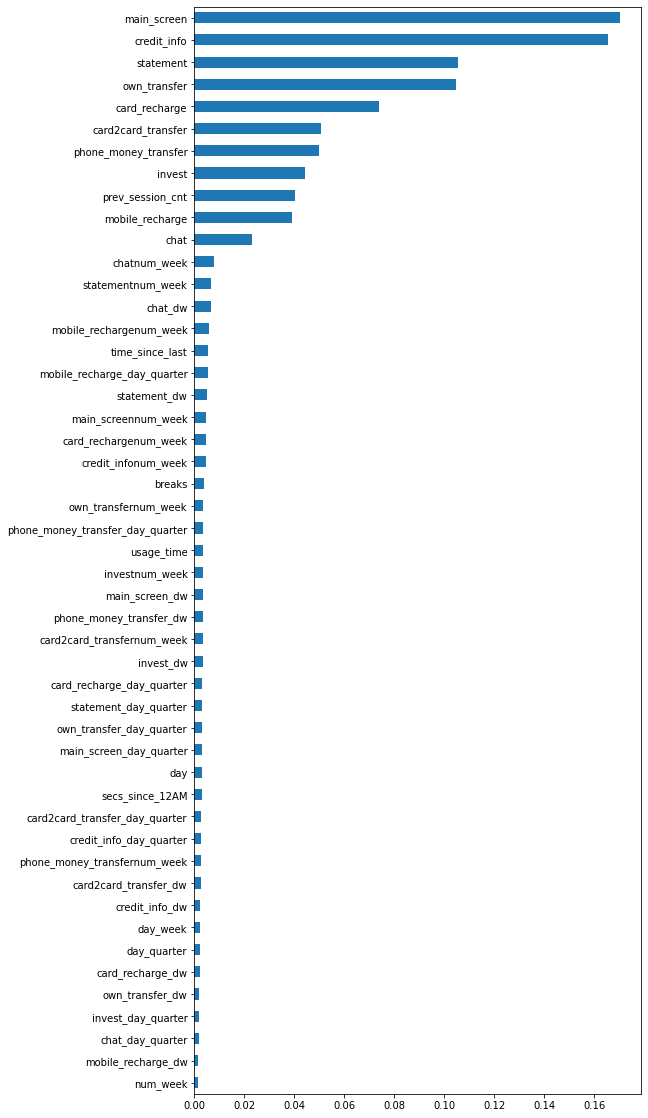

In [81]:
pd.Series(dict(zip(df.iloc[:, 4:].columns, xgb.feature_importances_))).sort_values().plot.barh(figsize=(8, 20))

In [38]:
score(y_val, xgb.predict(X_val))

0.43435709672247197

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_train, xgb.predict(X_train)))

                      precision    recall  f1-score   support

  card2card_transfer       0.39      0.13      0.19      4805
       card_recharge       0.49      0.31      0.38      3311
                chat       0.51      0.15      0.23      4554
         credit_info       0.58      0.63      0.60     11818
              invest       0.68      0.36      0.47      1138
         main_screen       0.62      0.83      0.71     55557
     mobile_recharge       0.41      0.12      0.19      6502
        own_transfer       0.49      0.53      0.51      7184
phone_money_transfer       0.46      0.13      0.20      5991
           statement       0.50      0.43      0.46     22153

            accuracy                           0.58    123013
           macro avg       0.51      0.36      0.40    123013
        weighted avg       0.55      0.58      0.54    123013



In [14]:
import pickle
pickle.dump(xgb, open('xgboost', 'wb'))

### Extract test features

In [41]:
import numpy as np

# рекурсивный алгоритм вычисления экспоненциального среднего по каждому классу
def EMA(alfa, array: np.ndarray, idx=None):
    if idx is None:
        return EMA(alfa, array, array.shape[0]-1)
    if idx == 0:
        return array.mean(0)
    else:
        return alfa * array[idx] + (1 - alfa) * EMA(alfa, array, idx-1)

# максимальное количество сессий у клиента ~1600 => увеличим максимальную глубина рекурсиии
import sys
sys.setrecursionlimit(2000)

# посчитать вероятности каждого класса на основании предыдущих сессий
def get_class_probs(data: pd.DataFrame, suffix=''):
    if len(data):
        class_array = lb.transform(data.multi_class_target)
        prev_acts = EMA(ALFA_COEF, class_array).astype('float16')
        prev_acts = {x+suffix: y for x, y in zip(CLASSES, prev_acts)}
        return prev_acts
        
    return {x+suffix: None for x in CLASSES}

In [56]:
day2num_week = {i: i // 8 for i in range(1, 32)}
hour2quarter = {i: i // 6 for i in range(24)}

def cur_time_info(cur_time: pd.Timestamp):
    time_dict = OrderedDict()

    # сколько времени прошло с полуночи
    time_dict['secs_since_12AM'] = 3600 * cur_time.hour + 60 * cur_time.minute + cur_time.second

    # день месяца
    time_dict['day'] = cur_time.day

    # день недели
    time_dict['day_week'] = cur_time.dayofweek

    # четверть месяца
    time_dict['num_week'] = day2num_week.get(cur_time.day, -1)

    # интервалы суток (по 6 часов)
    time_dict['day_quarter'] = hour2quarter.get(cur_time.hour, -1)

    return time_dict

In [83]:
from collections import OrderedDict

def test_feature_extractor(df: pd.DataFrame, client_pin, cur_time) -> dict:
    out = OrderedDict(client=client_pin)
    out.update(cur_time_info(cur_time))
    #количество предыдущих сессий
    out['prev_session_cnt'] = len(df)

    if out['prev_session_cnt']:
        # timestamp первой сессии
        first_session_ts = data.timestamp.iloc[0]

        # время с последней сессии
        out['time_since_last'] = (cur_time - df.timestamp.iloc[-1]).total_seconds()

        # сколько всего пользуется приложением
        out['usage_time'] = cur_time.timestamp() - first_session_ts.timestamp()

        # в среднем перерывы между сессиями
        out['breaks'] = out['usage_time'] / out['prev_session_cnt']

        # вероятность действия X
        prev_acts = get_class_probs(df)
        out.update(prev_acts)

        # вероятность действия по интервалам суток
        df_spam_quarter = df[df.timestamp.dt.hour.map(hour2quarter).eq(out['day_quarter'])]
        prev_acts_quarter = get_class_probs(df_spam_quarter, suffix='_day_quarter')
        out.update(prev_acts_quarter)

        # вероятность действия Х по текущему дню недели
        df_spam_dw = df[df.timestamp.dt.dayofweek.eq(out['day_week'])]
        prev_acts_dayweek = get_class_probs(df_spam_dw, suffix='_dw')
        out.update(prev_acts_dayweek)

        # вероятность по текущей четверти месяца
        df_spam_month = df[df.timestamp.dt.day.map(day2num_week).eq(out['num_week'])]
        prev_acts_month = get_class_probs(df_spam_month, suffix='num_week')
        out.update(prev_acts_month)
    return out

In [90]:
test_feature_names = list(test_feature_extractor(data, client, test[client]).keys())

with open('test_features.csv', mode='w') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(test_feature_names)
    
    for client, data in tqdm(train.groupby('client_pin')):
        timestamp = test[client]
        writer.writerow(test_feature_extractor(data, client, timestamp).values())

  0%|          | 0/79268 [00:00<?, ?it/s]

### Test prediction

In [25]:
test = pd.read_csv('test_features.csv')
test[to_scale] = scaler.transform(test[to_scale])
test.fillna(0, inplace=True)

Предсказания моделей, построенных на разных фичах

In [26]:
predicts = make_predictions(models, test)
test['prediction'] = predicts
test[['client', 'prediction']].rename({'client': 'client_pin'}, axis=1).to_csv('pred_svc_multi.csv', index=False)

  0%|          | 0/10 [00:00<?, ?it/s]

Предсказания бустинга

In [47]:
X_test = csr_matrix(test.iloc[:, 1:].astype(float))

In [48]:
preds = pd.Series(dict(zip(test['client'], xgb.predict(X_test))))

In [49]:
subm = pd.read_csv('alfabattle2_abattle_sample_prediction.csv')

In [50]:
subm.prediction = subm.client_pin.map(preds)

In [51]:
subm.to_csv('pred_xgb.csv', index=False)